In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:

cd drive/MyDrive/Liveness Detection

/content/drive/MyDrive/Liveness Detection


In [ ]:
# !unzip public/frames.zip   

In [ ]:
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

import tqdm
import random
import pathlib
import itertools
import collections
import pandas as pd
import numpy as np
from tensorflow import keras

import os
import cv2
import numpy as np
import remotezip as rz
from sklearn.model_selection import train_test_split

import tensorflow as tf
from pathlib import Path

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
RANDOM_SEED = 21  # Random seed for consistent data splits
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
LEARNING_RATE = 1e-4
N_EPOCHS = 300
N_FRAMES = 10
PATH = "train/frames"

In [ ]:
# def format_frames(frame, output_size):
#   """
#     Pad and resize an image from a video.

#     Args:
#       frame: Image that needs to resized and padded. 
#       output_size: Pixel size of the output frame image.

#     Return:
#       Formatted frame with padding of specified output size.
#   """
#   frame = tf.image.convert_image_dtype(frame, tf.float32)
#   frame = tf.image.resize_with_pad(frame, *output_size)
#   return frame


In [ ]:
# import os
# def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
#   """
#     Creates frames from each video file present for each category.

#     Args:
#       video_path: File path to the video.
#       n_frames: Number of frames to be created per video file.
#       output_size: Pixel size of the output frame image.

#     Return:
#       An NumPy array of frames in the shape of (n_frames, height, width, channels).
#   """
#   # Read each video frame by frame
#   result = []
#   src = cv2.VideoCapture(str(video_path))  

#   video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

#   need_length = 1 + (n_frames - 1) * frame_step

#   if need_length > video_length:
#     start = 0
#   else:
#     max_start = video_length - need_length
#     start = random.randint(0, max_start + 1)

#   src.set(cv2.CAP_PROP_POS_FRAMES, start)
#   # ret is a boolean indicating whether read was successful, frame is the image itself
#   ret, frame = src.read()
#   frame_dir = os.path.join("train/frames",video_path.split("/")[2].split(".")[0]) 
#   os.mkdir(frame_dir)
#   cv2.imwrite(os.path.join(frame_dir , "0.jpg"), frame)
#   print(frame_dir + "0.jpg")
#   for idx in range(1, n_frames):
#     for _ in range(frame_step):
#       ret, frame = src.read()
#     if ret:
#       cv2.imwrite(os.path.join(frame_dir , str(idx) + ".jpg"), frame)
#   src.release()



In [ ]:
# for video_name in annotations[397:,0]:
#   video_path = os.path.join("train/videos", video_name)
#   print(video_path)
#   sample_video = frames_from_video_file(video_path, n_frames = 10)

In [ ]:
# len(os.listdir( "train/videos"))

In [ ]:
# video_path  = "train/videos/1.mp4"

In [ ]:
# sample_video = frames_from_video_file(video_path, n_frames = 10)
# type(sample_video)


In [ ]:
# def to_gif(images):
#   converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
#   imageio.mimsave('./animation.gif', converted_images, fps=10)
#   return embed.embed_file('./animation.gif')


In [ ]:
def read_annotations(annotations_path):
  df = pd.read_csv(annotations_path)
  annotations = []
  idx = 0
  for i in df:
    if idx == 0:      
      for j in range(len(df)):
        annotation = []
        annotation.append(df[i][j])
        annotations.append(annotation)
    else:
      for j in range(len(df)):
        annotations[j].append(df[i][j])
    idx += 1
  return annotations

In [ ]:
annotations = read_annotations("train/label.csv")

In [ ]:
len(os.listdir("train/frames"))

1168

In [ ]:
len(annotations)

1168

In [ ]:
def get_frames_annotations(annotations):
  for annotation_idx in range(len(annotations)):
    name_frame = annotations[annotation_idx][0].split(".")[0]
    annotations[annotation_idx][0] = name_frame
  return annotations

In [ ]:
annotations = get_frames_annotations(annotations)

In [ ]:
def split(annotations, random_state, valid_size):
  train_annotations, valid_annotations = train_test_split(
      annotations, test_size = valid_size, random_state = random_state
  )
  return train_annotations, valid_annotations

In [ ]:
train_annotations, valid_annotations = split(
    annotations, random_state= RANDOM_SEED, valid_size= 0.1
)

In [ ]:
import numpy as np
from skimage import feature as skif
import cv2
def lbp_histogram(image,P=8,R=1,method = 'nri_uniform'):
    '''
    image: shape is N*M 
    '''
    lbp = skif.local_binary_pattern(image, P,R, method) # lbp.shape is equal image.shape
    # cv2.imwrite("lbp.png",lbp)
    max_bins = int(lbp.max() + 1) # max_bins is related P
    hist,_= np.histogram(lbp,  normed=True, bins=max_bins, range=(0, max_bins))
    return hist
# file_list is a txt file, like this:
# image_path label
def save_features(file_list,file_name):
    feature_label = []
    for line in open(file_list):
        image_path = line.strip().split(' ')[0]
        label = int(line.strip().split(' ')[1])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        y_h = lbp_histogram(image[:,:,0]) # y channel
        cb_h = lbp_histogram(image[:,:,1]) # cb channel
        cr_h = lbp_histogram(image[:,:,2]) # cr channel
        feature = np.concatenate((y_h,cb_h,cr_h))
        feature_label.append(np.append(feature,np.array(label)))

In [ ]:
from pathlib import Path
class FrameGenerator:
  def __init__(self, path, annotations, image_size):
  
    self.path = path
    self.image_size = image_size
    self.annotations = annotations

  def __call__(self):
    for annotation in self.annotations:
      frames_path = os.path.join(self.path, annotation[0])
      n_frames = len(os.listdir(frames_path))
      label = annotation[1]
      for frame_name in os.listdir(frames_path):
        image_path = os.path.join(frames_path, frame_name)
        image = keras.utils.load_img(str(image_path))
        image = image.resize(self.image_size)
        image = keras.preprocessing.image.img_to_array(image, dtype="uint8")
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        label = tf.convert_to_tensor(int(label), dtype=tf.float32)
        his_image = cv2.imread(image_path)
        his_image = cv2.resize(his_image, self.image_size)
        his_image = cv2.cvtColor(his_image, cv2.COLOR_BGR2YCrCb)
        y_h = lbp_histogram(his_image[:,:,0]) # y channel
        cb_h = lbp_histogram(his_image[:,:,1]) # cb channel
        cr_h = lbp_histogram(his_image[:,:,2]) # cr channel
        feature = np.concatenate((y_h,cb_h,cr_h))
        feature = tf.convert_to_tensor(feature, dtype=tf.float32)
        yield {"input_1": image, "input_2": feature}, label


In [ ]:
from pathlib import Path
class OnlyFrameGenerator:
  def __init__(self, path, annotations, image_size):
  
    self.path = path
    self.image_size = image_size
    self.annotations = annotations

  def __call__(self):
    for annotation in self.annotations:
      frames_path = os.path.join(self.path, annotation[0])
      n_frames = len(os.listdir(frames_path))
      label = annotation[1]
      for frame_name in os.listdir(frames_path):
        image_path = os.path.join(frames_path, frame_name)
        image = keras.utils.load_img(str(image_path))
        image = image.resize(self.image_size)
        image = keras.preprocessing.image.img_to_array(image, dtype="uint8")
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        yield  image

In [ ]:
from pathlib import Path
class FeatureGenerator:
  def __init__(self, path, annotations, image_size):
  
    self.path = path
    self.image_size = image_size
    self.annotations = annotations

  def __call__(self):
    for annotation in self.annotations:
      frames_path = os.path.join(self.path, annotation[0])
      n_frames = len(os.listdir(frames_path))
      label = annotation[1]
      for frame_name in os.listdir(frames_path):
        image_path = os.path.join(frames_path, frame_name)
        his_image = cv2.imread(image_path)
        his_image = cv2.resize(his_image, self.image_size)
        his_image = cv2.cvtColor(his_image, cv2.COLOR_BGR2YCrCb)
        y_h = lbp_histogram(his_image[:,:,0]) # y channel
        cb_h = lbp_histogram(his_image[:,:,1]) # cb channel
        cr_h = lbp_histogram(his_image[:,:,2]) # cr channel
        feature = np.concatenate((y_h,cb_h,cr_h))
        feature = tf.convert_to_tensor(feature, dtype=tf.float32)
        yield feature

In [ ]:
from pathlib import Path
class LabelGenerator:
  def __init__(self, path, annotations, image_size):
  
    self.path = path
    self.image_size = image_size
    self.annotations = annotations

  def __call__(self):
    for annotation in self.annotations:
      frames_path = os.path.join(self.path, annotation[0])
      n_frames = len(os.listdir(frames_path))
      label = annotation[1]
      for frame_name in os.listdir(frames_path):
        label = tf.convert_to_tensor(int(label), dtype=tf.float32)
        yield label

In [ ]:
frame_ds = tf.data.Dataset.from_generator(OnlyFrameGenerator(PATH, train_annotations, IMAGE_SIZE),
                                           output_types=(tf.float32))
feature_ds = tf.data.Dataset.from_generator(FeatureGenerator(PATH, train_annotations, IMAGE_SIZE),
                                           output_types=(tf.float32))
label_ds = tf.data.Dataset.from_generator(LabelGenerator(PATH, train_annotations, IMAGE_SIZE),
                                           output_types=(tf.int16))
inputs_ds = tf.data.Dataset.zip((frame_ds, feature_ds))
train_ds =  tf.data.Dataset.zip((inputs_ds, label_ds))

In [ ]:
# Create the training set
output_signature = (tf.TensorSpec(shape = ( None, None, 3), dtype = tf.float32), tf.TensorSpec(shape = (177), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(PATH, train_annotations, IMAGE_SIZE),
                                           output_types=({"input_1": tf.float32, "input_2": tf.float32}, tf.int16))
val_ds = tf.data.Dataset.from_generator(FrameGenerator(PATH, valid_annotations, IMAGE_SIZE),
                                          output_types=({"input_1": tf.float32, "input_2": tf.float32}, tf.int16))


In [ ]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

# train_frames, train_labels = next(iter(train_ds))
# print(f'Shape of training set of frames: {train_frames.shape}')
# print(f'Shape of training labels: {train_labels.shape}')

# val_frames, val_labels = next(iter(val_ds))
# print(f'Shape of validation set of frames: {val_frames.shape}')
# print(f'Shape of validation labels: {val_labels.shape}')


In [ ]:
# len(list(train_ds))

In [ ]:
def ConvBlock(input_shape, kernel_size):
  block = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    tf.keras.layers.Conv2D(3,kernel_size),
    tf.keras.layers.BatchNormalization(),
  ])
  return block

In [ ]:
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Concatenate, BatchNormalization
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
net = tf.keras.applications.MobileNetV2(
    include_top=False,
)
# net.trainable = False
input1 = keras.Input(shape = (224,224,3), name='input_1')
x = net(input1)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation= 'relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(256, activation= 'relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(128, activation= 'relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(32, activation= 'relu')(x)
x = Dropout(0.2)(x)

input2 = keras.Input(shape = (177), name='input_2')
y = BatchNormalization()(input2)
y = Dense(128, activation= 'relu')(y)
y = Dropout(0.2)(y)
y = BatchNormalization()(y)
y = Dense(64, activation= 'relu')(y)
y = Dropout(0.2)(y)
y = BatchNormalization()(y)
y = Dense(32, activation= 'relu')(y)
y = Dropout(0.2)(y)

merge = Concatenate()([x, y])
dense = BatchNormalization()(merge)
dense = Dense(128, activation = 'relu')(dense)
dense = Dropout(0.2)(dense)
dense = BatchNormalization()(merge)
outputs = Dense(1)(dense)

model = Model(inputs = [input1, input2], outputs =outputs)

# from tqdm import tqdm
# model = tf.keras.Sequential([
#     tf.keras.Input(shape=(224,224,3)),
#     net,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation= 'relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(256, activation= 'relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(128, activation= 'relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1),
# ])
model.summary()
model.compile(optimizer = 'adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds, 
          epochs = 10,
          # validation_data = val_ds,
)


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, None, None,   2257984    ['input_1[0][0]']                
 al)                            1280)                                                             
                                                                                                  
 global_average_pooling2d_9 (Gl  (None, 1280)        0           ['mobilenetv2_1.00_224[0][0]']   
 obalAveragePooling2D)                                                                      

ValueError: ignored

In [ ]:
tf.keras.utils.plot_model(model)


In [ ]:
import numpy as np
from skimage import feature as skif
import cv2
def lbp_histogram(image,P=8,R=1,method = 'nri_uniform'):
    '''
    image: shape is N*M 
    '''
    lbp = skif.local_binary_pattern(image, P,R, method) # lbp.shape is equal image.shape
    # cv2.imwrite("lbp.png",lbp)
    max_bins = int(lbp.max() + 1) # max_bins is related P
    hist,_= np.histogram(lbp,  normed=True, bins=max_bins, range=(0, max_bins))
    return hist
# file_list is a txt file, like this:
# image_path label
def save_features(file_list,file_name):
    feature_label = []
    for line in open(file_list):
        image_path = line.strip().split(' ')[0]
        label = int(line.strip().split(' ')[1])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        y_h = lbp_histogram(image[:,:,0]) # y channel
        cb_h = lbp_histogram(image[:,:,1]) # cb channel
        cr_h = lbp_histogram(image[:,:,2]) # cr channel
        feature = np.concatenate((y_h,cb_h,cr_h))
        feature_label.append(np.append(feature,np.array(label)))

In [ ]:
from pathlib import Path
class HistogramGenerator:
  def __init__(self, path, annotations, image_size):
  
    self.path = path
    self.image_size = image_size
    self.annotations = annotations

  def __call__(self):
    for annotation in self.annotations:
      frames_path = os.path.join(self.path, annotation[0])
      n_frames = len(os.listdir(frames_path))
      label = annotation[1]
      for frame_name in os.listdir(frames_path):
        image_path = os.path.join(frames_path, frame_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, self.image_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        y_h = lbp_histogram(image[:,:,0]) # y channel
        cb_h = lbp_histogram(image[:,:,1]) # cb channel
        cr_h = lbp_histogram(image[:,:,2]) # cr channel
        feature = np.concatenate((y_h,cb_h,cr_h))
        feature = tf.convert_to_tensor(feature, dtype=tf.float32)
        label = tf.convert_to_tensor(int(label), dtype=tf.float32)
        yield feature, label


In [ ]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (177), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
his_train_ds = tf.data.Dataset.from_generator(HistogramGenerator(PATH, train_annotations, IMAGE_SIZE),
                                          output_signature = output_signature)
his_val_ds = tf.data.Dataset.from_generator(HistogramGenerator(PATH, valid_annotations, IMAGE_SIZE),
                                          output_signature = output_signature)


In [ ]:
# Print the shapes of the data
train_frames, train_labels = next(iter(his_train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(his_val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')


Shape of training set of frames: (177,)
Shape of training labels: ()
Shape of validation set of frames: (177,)
Shape of validation labels: ()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
his_train_ds = his_train_ds.batch(32)
his_val_ds = his_val_ds.batch(32)

# train_frames, train_labels = next(iter(train_ds))
# print(f'Shape of training set of frames: {train_frames.shape}')
# print(f'Shape of training labels: {train_labels.shape}')

# val_frames, val_labels = next(iter(val_ds))
# print(f'Shape of validation set of frames: {val_frames.shape}')
# print(f'Shape of validation labels: {val_labels.shape}')


In [ ]:

# net.trainable = False
from tqdm import tqdm
model = tf.keras.Sequential([
    tf.keras.Input(shape=(177)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1),
])
model.summary()
model.compile(optimizer = 'adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(his_train_ds, 
          epochs = 10,
          validation_data = his_val_ds,
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 177)              708       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 128)               22784     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # This is added back by InteractiveShellApp.init_path()


323/323 [==============================] - 513s 2s/step - loss: 0.6196 - accuracy: 0.6657 - val_loss: 0.6796 - val_accuracy: 0.7624
Epoch 2/10
323/323 [==============================] - 508s 2s/step - loss: 0.5258 - accuracy: 0.7325 - val_loss: 0.4997 - val_accuracy: 0.8035
Epoch 3/10
323/323 [==============================] - 502s 2s/step - loss: 0.4748 - accuracy: 0.7676 - val_loss: 0.4162 - val_accuracy: 0.8183
Epoch 4/10
187/323 [================>.............] - ETA: 3:08 - loss: 0.4490 - accuracy: 0.7871

In [ ]:
model.fit(his_train_ds, 
          epochs = 10,
          validation_data = his_val_ds,
)

In [ ]:
model.save('histogram_classify.h5')

In [ ]:
image_path = "train/frames/1/1.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
print(image[:,:,0])
y_h = lbp_histogram(image[:,:,0]) # y channel
cb_h = lbp_histogram(image[:,:,1]) # cb channel
cr_h = lbp_histogram(image[:,:,2]) # cr channel
feature = np.concatenate((y_h,cb_h,cr_h))
feature.shape


[[33 33 33 ... 18 14 11]
 [33 33 33 ... 18 14 11]
 [33 33 33 ... 19 14 10]
 ...
 [76 79 81 ... 91 91 91]
 [74 77 81 ... 91 90 91]
 [72 77 81 ... 91 90 91]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # This is added back by InteractiveShellApp.init_path()


(177,)

1240
1453
1336
1109
1373
1195
1233
1326
1148
1644
1110
1627
1388
1081
1658
1136
1119
1620
1556
1654


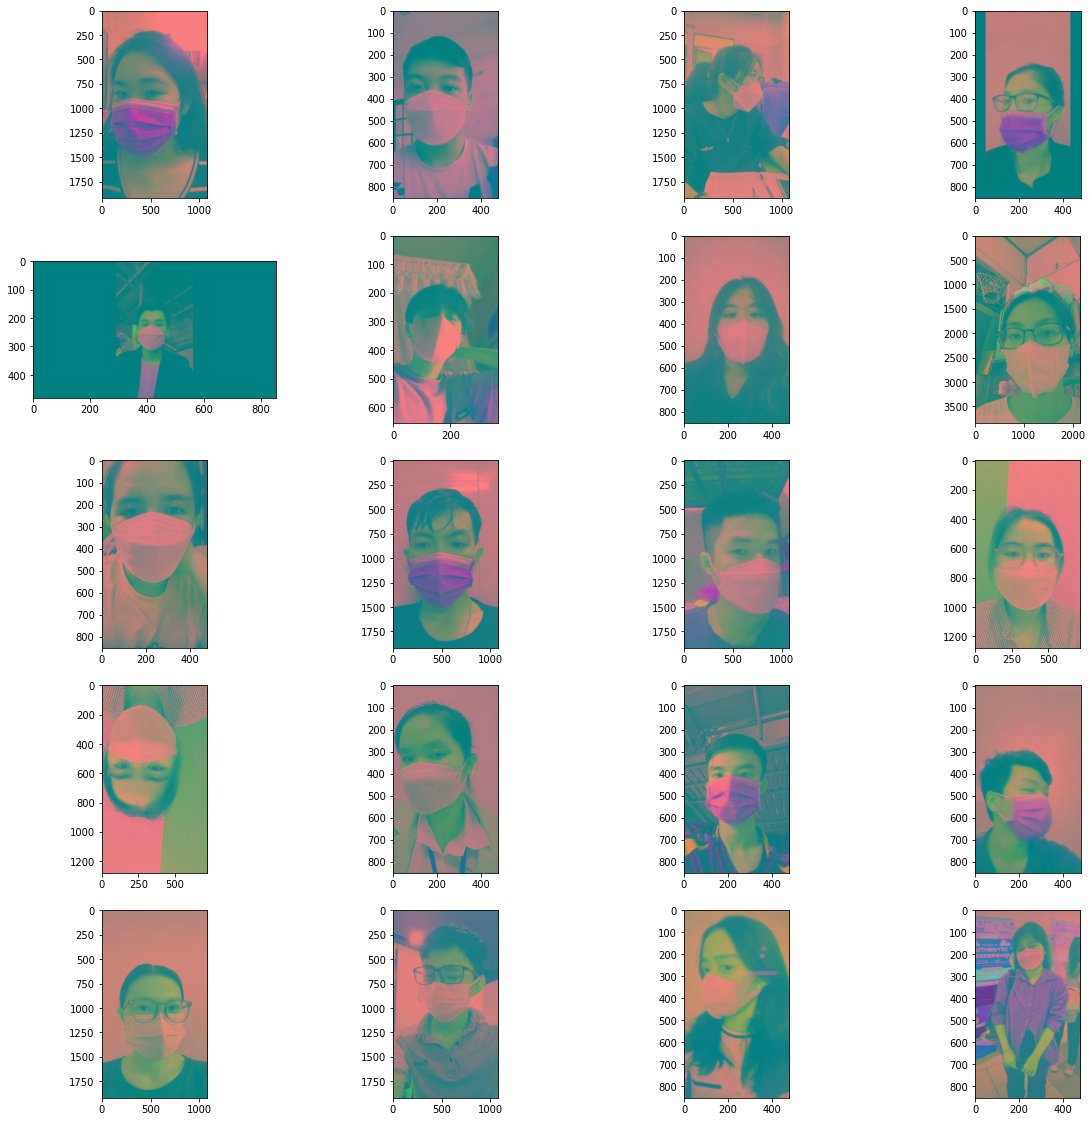

In [ ]:
image_path = "train/frames"
import matplotlib.pyplot as plt
w = 10
h = 10
fig = plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    name_image = os.path.join(image_path, os.listdir(image_path)[i], "0.jpg")
    print(os.listdir(image_path)[i])
    image = cv2.imread(name_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
plt.show()

In [ ]:
from pathlib import Path
class TestFrameGenerator:
  def __init__(self, path, image_size):
  
    self.path = path
    self.image_size = image_size

  def __call__(self):
    for annotation in os.listdir(self.path):
      frames_path = os.path.join(self.path, annotation)
      print(frames_path)
      n_frames = len(os.listdir(frames_path))
      for frame_name in os.listdir(frames_path):
        image_path = os.path.join(frames_path, frame_name)
        image = keras.utils.load_img(str(image_path))
        image = image.resize(self.image_size)
        image = keras.preprocessing.image.img_to_array(image, dtype="uint8")
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        yield image

In [ ]:
# Create the training set
output_signature = (tf.TensorSpec(shape = ( None, None, 3), dtype = tf.float32))
test_ds = tf.data.Dataset.from_generator(TestFrameGenerator("public/frames", IMAGE_SIZE),
                                          output_signature = output_signature)
test_ds = test_ds.batch(32)


In [ ]:
test_frames = next(iter(test_ds))
test_frames

public/frames/480
public/frames/4
public/frames/484
public/frames/5
public/frames/479
public/frames/481
public/frames/6
public/frames/2
public/frames/21


<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[151., 141., 129.],
         [151., 141., 127.],
         [153., 142., 127.],
         ...,
         [181., 179., 167.],
         [181., 178., 167.],
         [179., 178., 166.]],

        [[149., 143., 129.],
         [150., 143., 129.],
         [152., 144., 129.],
         ...,
         [182., 180., 168.],
         [182., 180., 168.],
         [180., 180., 168.]],

        [[150., 146., 134.],
         [151., 147., 134.],
         [153., 148., 133.],
         ...,
         [182., 181., 169.],
         [183., 181., 169.],
         [182., 182., 170.]],

        ...,

        [[  1.,   1.,   1.],
         [  1.,   1.,   1.],
         [  1.,   1.,   1.],
         ...,
         [  2.,   3.,   5.],
         [  1.,   2.,   4.],
         [  1.,   2.,   4.]],

        [[  1.,   1.,   2.],
         [  1.,   1.,   2.],
         [  1.,   1.,   2.],
         ...,
         [  1.,   2.,   4.],
         [  1.,   2.,   4.],
        

In [ ]:
test_pred = model.predict(test_ds)

public/frames/480
public/frames/4
public/frames/484
public/frames/5
public/frames/479
public/frames/481
public/frames/6
public/frames/2
public/frames/21
      1/Unknown - 1s 841ms/steppublic/frames/15
public/frames/0
public/frames/23
public/frames/1
public/frames/483
public/frames/13
public/frames/10
      2/Unknown - 1s 308ms/steppublic/frames/22
public/frames/3
public/frames/20
public/frames/16
public/frames/18
public/frames/12
public/frames/7
public/frames/14
      3/Unknown - 1s 327ms/steppublic/frames/19
public/frames/11
public/frames/8
public/frames/9
public/frames/485
public/frames/478
public/frames/477
public/frames/470
public/frames/17
      4/Unknown - 2s 372ms/steppublic/frames/469
public/frames/472
public/frames/475
public/frames/465
public/frames/476
public/frames/471
public/frames/466
      5/Unknown - 2s 391ms/steppublic/frames/474
public/frames/467
public/frames/482
public/frames/464
public/frames/462
public/frames/457
public/frames/460
      6/Unknown - 3s 398ms/steppu

In [ ]:
len(test_pred)  

2000

In [ ]:
a = tf.keras.activations.sigmoid(test_pred).numpy()
b = (a > 0.5).astype(int)


In [ ]:
path = "public/frames"
for annotation in os.listdir(path):
      frames_path = os.path.join(path, annotation)
      print(frames_path)
      n_frames = len(os.listdir(frames_path))
      for frame_name in os.listdir(frames_path):
        image_path = os.path.join(frames_path, frame_name)
        image = keras.utils.load_img(str(image_path))
        image = image.resize(IMAGE_SIZE)
        image = keras.preprocessing.image.img_to_array(image, dtype="uint8")
        image = tf.convert_to_tensor(image, dtype=tf.float32)


public/frames/480
public/frames/4
public/frames/484
public/frames/5
public/frames/479
public/frames/481
public/frames/6
public/frames/2
public/frames/21
public/frames/15
public/frames/0
public/frames/23
public/frames/1
public/frames/483
public/frames/13
public/frames/10
public/frames/22
public/frames/3
public/frames/20
public/frames/16
public/frames/18
public/frames/12
public/frames/7
public/frames/14
public/frames/19
public/frames/11
public/frames/8
public/frames/9
public/frames/485
public/frames/478
public/frames/477
public/frames/470
public/frames/17
public/frames/469
public/frames/472
public/frames/475
public/frames/465
public/frames/476
public/frames/471
public/frames/466
public/frames/474
public/frames/467
public/frames/482
public/frames/464
public/frames/462
public/frames/457
public/frames/460
public/frames/473
public/frames/458
public/frames/452
public/frames/455
public/frames/453
public/frames/454
public/frames/468
public/frames/449
public/frames/448
public/frames/443
public/f

In [ ]:
#write csv
import csv
i = 0
with open('predict.csv', 'w', encoding='UTF8') as f:
  path = "public/frames"
  writer = csv.writer(f)
  header = ["fname", "liveness_score"]
  writer.writerow(header)
  for annotation in os.listdir(path):
      row = []
      frames_path = os.path.join(path, annotation)
      n_frames = len(os.listdir(frames_path))
      video_name = annotation + ".mp4"
      kq = 0
      num = 0
      for frame_name in os.listdir(frames_path):
        kq += (b[i][0])
        i += 1
        num += 1
      kq = kq/num
      if kq > 0.5:
        kq = 1
      else:
        kq = 0
      row = [video_name, kq]
      writer.writerow(row)
      print(row)
      print(video_name)



['480.mp4', 0]
480.mp4
['4.mp4', 0]
4.mp4
['484.mp4', 0]
484.mp4
['5.mp4', 0]
5.mp4
['479.mp4', 1]
479.mp4
['481.mp4', 1]
481.mp4
['6.mp4', 1]
6.mp4
['2.mp4', 1]
2.mp4
['21.mp4', 1]
21.mp4
['15.mp4', 0]
15.mp4
['0.mp4', 0]
0.mp4
['23.mp4', 0]
23.mp4
['1.mp4', 1]
1.mp4
['483.mp4', 0]
483.mp4
['13.mp4', 1]
13.mp4
['10.mp4', 1]
10.mp4
['22.mp4', 1]
22.mp4
['3.mp4', 0]
3.mp4
['20.mp4', 0]
20.mp4
['16.mp4', 0]
16.mp4
['18.mp4', 1]
18.mp4
['12.mp4', 1]
12.mp4
['7.mp4', 0]
7.mp4
['14.mp4', 0]
14.mp4
['19.mp4', 0]
19.mp4
['11.mp4', 0]
11.mp4
['8.mp4', 1]
8.mp4
['9.mp4', 0]
9.mp4
['485.mp4', 0]
485.mp4
['478.mp4', 0]
478.mp4
['477.mp4', 0]
477.mp4
['470.mp4', 0]
470.mp4
['17.mp4', 1]
17.mp4
['469.mp4', 0]
469.mp4
['472.mp4', 1]
472.mp4
['475.mp4', 0]
475.mp4
['465.mp4', 1]
465.mp4
['476.mp4', 0]
476.mp4
['471.mp4', 0]
471.mp4
['466.mp4', 0]
466.mp4
['474.mp4', 0]
474.mp4
['467.mp4', 1]
467.mp4
['482.mp4', 0]
482.mp4
['464.mp4', 1]
464.mp4
['462.mp4', 1]
462.mp4
['457.mp4', 1]
457.mp4
['460.mp4'

In [ ]:
path = "public/frames"
num = 0
for annotation in os.listdir(path):
    frames_path = os.path.join(path, annotation)
    n_frames = len(os.listdir(frames_path))
    for frame_name in os.listdir(frames_path):
      num += 1
num

3437

In [ ]:
(test_pred/(1-test_pred))

array([[-1.1653485],
       [-1.1815546],
       [-1.1499407],
       ...,
       [-1.234551 ],
       [-1.3889401],
       [-1.3068333]], dtype=float32)

In [ ]:
model.predict(train_ds)

323/323 [==============================] - 388s 1s/step


array([[-3.1116018],
       [-2.1584535],
       [-2.2318661],
       ...,
       [-0.8768413],
       [-1.184514 ],
       [-2.5488532]], dtype=float32)

In [ ]:
model.fit(train_ds, 
          epochs = 1,
          validation_data = val_ds,
)

323/323 [==============================] - 2434s 8s/step - loss: 0.1444 - accuracy: 0.9443 - val_loss: 0.4908 - val_accuracy: 0.8306


In [ ]:
model.save('partly_trained.h5')

In [ ]:

net = tf.keras.applications.regnet.RegNetX032(
    model_name='regnetx032',
    include_top=True,
    include_preprocessing=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

62258472/62258472 [==============================] - 4s 0us/step


In [ ]:
net.summary()

Model: "regnetx032"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 regnetx032_prestem_rescaling (  (None, 224, 224, 3)  0          ['input_3[0][0]']                
 Rescaling)                                                                                       
                                                                                                  
 regnetx032_stem_conv (Conv2D)  (None, 112, 112, 32  864         ['regnetx032_prestem_rescaling[0]
                                )                                [0]']                   

In [ ]:
for i in range(len(net.layers)):
  print(i)
  print(net.layers[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
